<a href="https://colab.research.google.com/github/Borg2/Arabic-Optical-Character-Recognition-OCR-/blob/main/data_processing_augmentation_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Processing and augmentation


## Importing the necessary libraries

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.model_selection import train_test_split
import kagglehub
import numpy as np
from sklearn.model_selection import train_test_split
import os
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import zscore

## Preprocessing the images

Preprocesses an image by resizing, converting it to grayscale, binarizing it (inverting black and white regions), and saving the processed image to a specified output folder.

In [2]:
def preprocess_image(image_path, output_folder):
    img = cv2.imread(image_path)

    resized_img = cv2.resize(img, (800, 600))

    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    _, binary_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    output_path = os.path.join(output_folder, os.path.basename(image_path))
    cv2.imwrite(output_path, binary_img)

In [3]:
# Download latest version
path =kagglehub.dataset_download("iraqyomar/khatt-arabic-hand-written-lines")
input_folder = os.path.join(path, "images")
#input_folder = '/kaggle/input/khatt-arabic-hand-written-lines/images'
output_folder = '/kaggle/working/output_images'


if not os.path.exists(output_folder):
    os.makedirs(output_folder)
#preprocess each image
for filename in os.listdir(input_folder):
    if filename.endswith('.tif') or filename.endswith(".jpg") or filename.endswith(".png"):
        image_path = os.path.join(input_folder, filename)
        preprocess_image(image_path, output_folder)

100%|██████████| 295M/295M [00:02<00:00, 154MB/s]

Extracting files...


resizing images, pairing them with their associated text labels, and storing the data in a pandas DataFrame for easier handling.

In [4]:
images_folder = '/kaggle/working/output_images'
#labels_folder = '/kaggle/input/khatt-arabic-hand-written-lines/labels'
labels_folder = os.path.join(path, "labels")
target_size = (800, 100)

data = []

for image_file in os.listdir(images_folder):
    if image_file.endswith(('.png', '.jpg', '.jpeg')):

        image_path = os.path.join(images_folder, image_file)
        image = Image.open(image_path)
        image_resized = image.resize(target_size)
        image_array = np.array(image_resized)

        # Get corresponding label
        label_file = os.path.splitext(image_file)[0] + '.txt'
        label_path = os.path.join(labels_folder, label_file)
        if os.path.exists(label_path):
            with open(label_path, 'r', encoding='windows-1256') as f:
                label = f.read().strip()
        else:
            label = None

        # Add image array and label to data list
        data.append({'image': image_array, 'label': label})

# Create DataFrame from the data list
df = pd.DataFrame(data)
df.head()

,image,label
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",خازن عفيف للحج . بدأت قوانل الحجيج حاج إثر # ...
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",خازن عفيف للحج. بدأت قوافل الحجيج حاج اثر أخر...
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",وليس هذا لمضمونه ومحتواه فقط ، بل لطريقة أدائه...
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",قادرين على تذكر وتمثيل جوانب متنوعة من الواقع ...
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",غيط ، ناء ، بث ، نسر


بكلمات لا أفهمها مثل انقض بغـلس له الضابط لزمتك. سألت


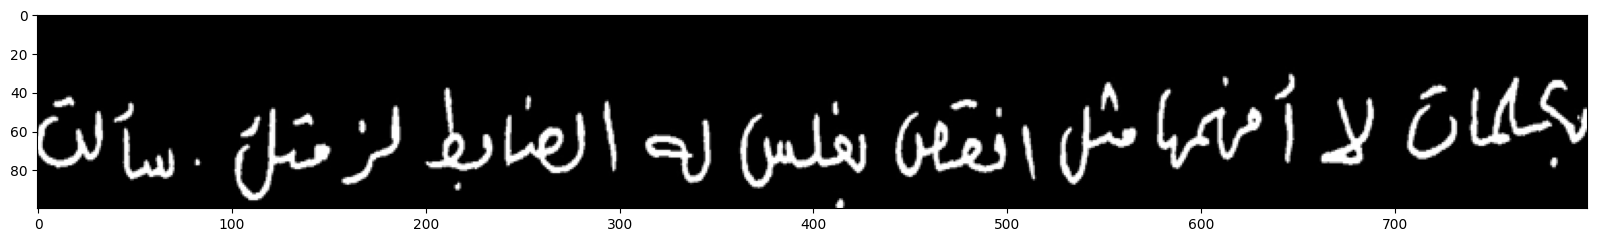

نظراٌ  لعدم وجود  بدائل اقتصادية أو زراعية ملائمة . والآثار المباشرة لنقص كمية الأمطار


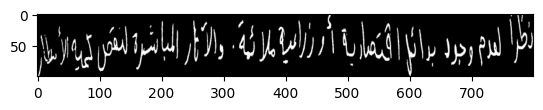

هل تعلم فائدة الكلمات التالية لهذا النص: مشمش، دراق، غيظ، ناء


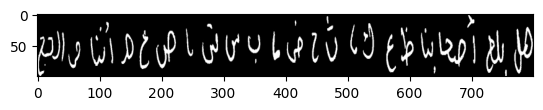

ذهب نوح مظفر ظرغام # بصحبه رؤوف بن لؤي رايق ظافر عطعوط وهلال


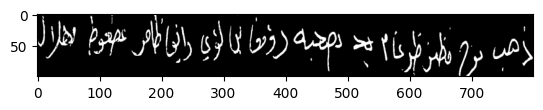

هل  تعلم فائدة  الكلمات التالية لهذا  النص : مشمش ، دراق، غيظ ، ناء ، بث ،نسر.


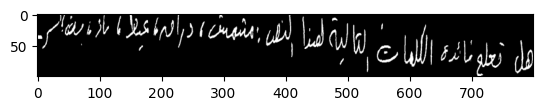

In [5]:
#Displaying sample of images with its labels

# Select random indices
random_indices = random.sample(range(len(df)), 5)  # Selecting 5 random images

# Plot images and labels
fig = plt.figure(figsize=(20, 4))
for i, idx in enumerate(random_indices, 1):
    image_array = df.loc[idx, 'image']
    label = df.loc[idx, 'label']
    plt.imshow(image_array,cmap = 'gray')
    print(label)
    plt.show()

## Data augmentation

This script performs image augmentation to enhance the diversity of training data. It includes the following functionalities:

1. **Geometric Distortion**: Applies random scaling and slight rotations to the image to simulate variations in size and orientation. This helps the model generalize to different perspectives and layouts.

2. **Perspective Transformation**: Alters the perspective of the image by shifting its corner points randomly. This simulates changes in viewing angles or camera positions, improving robustness to skewed inputs.

3. **Augmentations Workflow**:
   - Iterates over all input images and labels.
   - Applies each augmentation technique to generate new images while preserving the original labels.
   - Optionally visualizes the augmentations for inspection.

4. **Augmented Dataset Output**:
   - Returns an augmented dataset containing the original and modified images with their corresponding labels.
   - Prints the shapes of the augmented data for validation.



In [6]:
def geometric_distortion(image):
    """
    Apply geometric distortions to the image.

    Args:
        image (np.ndarray): Input image

    Returns:
        np.ndarray: Geometrically distorted image
    """
    rows, cols = image.shape

    scale_x = random.uniform(0.6, 1.4)
    scale_y = random.uniform(0.6, 1.4)

    angle = random.uniform(-3, 3)

    M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)

    distorted = cv2.warpAffine(image, M, (cols, rows))

    return cv2.resize(distorted, (cols, rows))


def perspective_transformation(image):
    """
    Apply perspective transformation to the image.

    Args:
        image (np.ndarray): Input image

    Returns:
        np.ndarray: Perspective-transformed image
    """
    rows, cols = image.shape

    src_points = np.float32([
        [0, 0],
        [cols-1, 0],
        [0, rows-1],
        [cols-1, rows-1]
    ])

    offset = 30
    dest_points = np.float32([
        [random.uniform(0, offset), random.uniform(0, offset)],
        [random.uniform(cols-1-offset, cols-1), random.uniform(0, offset)],
        [random.uniform(0, offset), random.uniform(rows-1-offset, rows-1)],
        [random.uniform(cols-1-offset, cols-1), random.uniform(rows-1-offset, rows-1)]
    ])

    M = cv2.getPerspectiveTransform(src_points, dest_points)
    transformed = cv2.warpPerspective(image, M, (cols, rows))

    return transformed

def augment_images(X, y, visualize=False):
    """
    Augment images with multiple techniques.

    Args:
        X (np.ndarray): Input images
        y (np.ndarray): Corresponding labels
        visualize (bool): Whether to visualize augmentations

    Returns:
        Tuple of augmented images and labels
    """
    X_augmented = []
    y_augmented = []

    viz_count = 0

    for image, label in zip(X, y):
        X_augmented.append(image)
        y_augmented.append(label)

        augmentation_techniques = [
            geometric_distortion,
            perspective_transformation
        ]

        for augment_func in augmentation_techniques:

            augmented_image = augment_func(image)

            if visualize and viz_count < 4:
                plt.figure(figsize=(15, 5))
                plt.subplot(131)
                plt.title('Original')
                plt.imshow(image, cmap='gray')
                plt.subplot(132)
                plt.title(augment_func.__name__)
                plt.imshow(augmented_image, cmap='gray')
                plt.show()
                viz_count += 1

            # Add augmented image
            X_augmented.append(augmented_image)
            y_augmented.append(label)

    return np.array(X_augmented), np.array(y_augmented)

def main(X, y, visualize=False):
    """
    Main augmentation workflow.

    Args:
        X (np.ndarray): Input images
        y (np.ndarray): Corresponding labels
        test_size (float): Proportion of test set
        random_state (int): Random seed for reproducibility
        visualize (bool): Whether to visualize augmentations

    Returns:
        Augmented training and test sets
    """

    X_train_augmented, y_train_augmented = augment_images(
        X, y, visualize=visualize
    )

    print("\nAugmented Dataset:")
    print(f"X_train_augmented shape: {X_train_augmented.shape}")
    print(f"y_train_augmented shape: {y_train_augmented.shape}")

    return X_train_augmented, y_train_augmented

### Splitting the data to train and test

In [7]:
# Convert image arrays to numpy arrays
X = np.array(df['image'].tolist())
y = df['label'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shape of the split datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (9100, 100, 800)
X_test shape: (2275, 100, 800)
y_train shape: (9100,)
y_test shape: (2275,)


لزمتك .  سألت راجح هل بلغ أصحابنا ظ ع ك ، ث خ ض، ب س ش، ص غ هـ


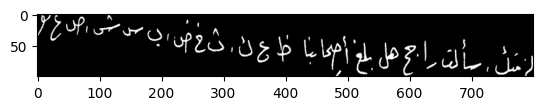

In [8]:
print(y_train[1000])
plt.imshow(X_train[1000],cmap = 'gray')

### Applying augmentation on the training data

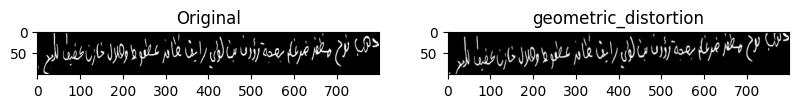

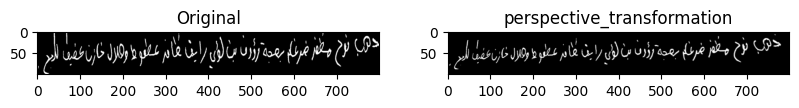

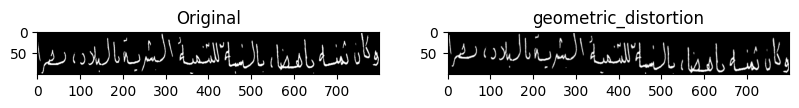

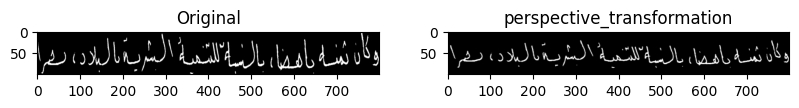


Augmented Dataset:
X_train_augmented shape: (27300, 100, 800)
y_train_augmented shape: (27300,)


In [9]:
#applying augmentation to the train data
X_train_aug, y_train_aug= main(X_train, y_train,visualize=True)

## Data visualization


calculate and compare pixel intensity statistics before and after image augmentation. Also plot histograms of pixel intensity distributions for better visualization.

In [11]:
def compute_pixel_values(images):
    pixel_values = []
    for img in images:
        pixel_values.extend(img.ravel())  # Append flattened pixel values
    return np.array(pixel_values)


In [ ]:
# Compute pixel values for both datasets
pixel_values = compute_pixel_values(X_train)
pixel_values_aug = compute_pixel_values(X_train_aug)

In [18]:
def compute_statistics(pixel_values, description=""):
    # Flatten all pixel values
    #pixel_values = np.array([img.ravel() for img in images]).flatten()

    # Compute statistics
    mean = np.mean(pixel_values)
    median = np.median(pixel_values)
    std_dev = np.std(pixel_values)

    # Print results
    print(f"--- Statistics {description} ---")
    print(f"Mean: {mean}")
    print(f"Median: {median}")
    print(f"Standard Deviation: {std_dev}")
    print()

In [19]:
# Compute statistics for original images
compute_statistics(pixel_values, description="Before Augmentation")

# Compute statistics for augmented images
compute_statistics(pixel_values_aug, description="After Augmentation")

--- Statistics Before Augmentation ---
Mean: 18.632010556318683
Median: 0.0
Standard Deviation: 61.05430734714

--- Statistics After Augmentation ---
Mean: 16.505024207875458
Median: 0.0
Standard Deviation: 56.070891226361425



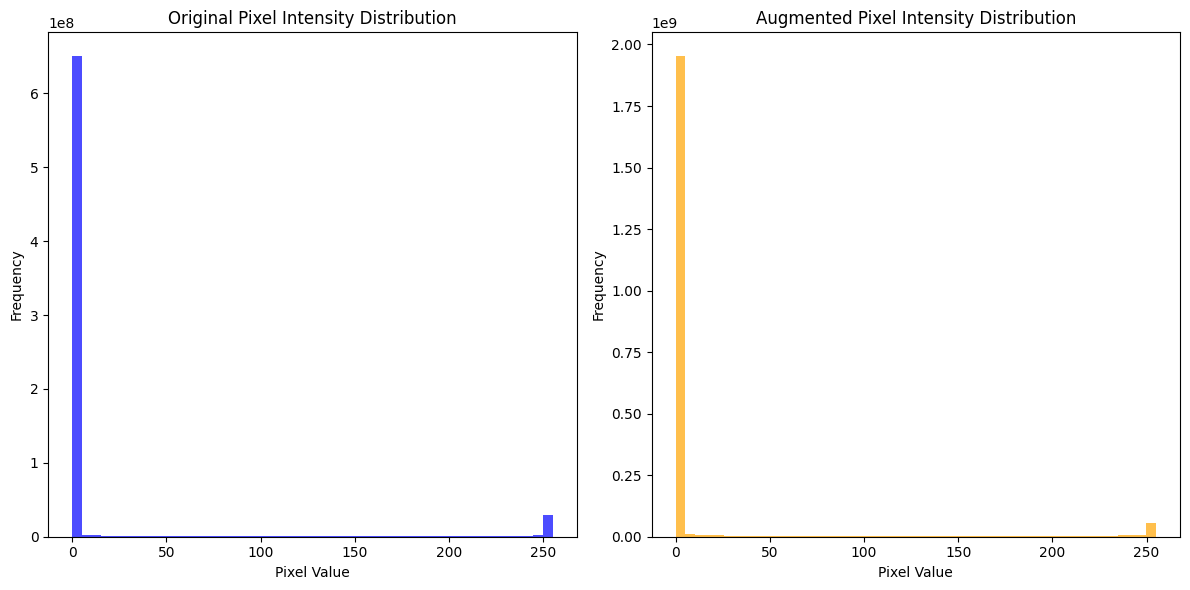

In [15]:
plt.figure(figsize=(12, 6))

# Histogram for original pixel values
plt.subplot(1, 2, 1)
plt.hist(pixel_values, bins=50, color='blue', alpha=0.7)
plt.title("Original Pixel Intensity Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")

# Histogram for augmented pixel values
plt.subplot(1, 2, 2)
plt.hist(pixel_values_aug, bins=50, color='orange', alpha=0.7)
plt.title("Augmented Pixel Intensity Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")

# Adjust layout
plt.tight_layout()
plt.show()

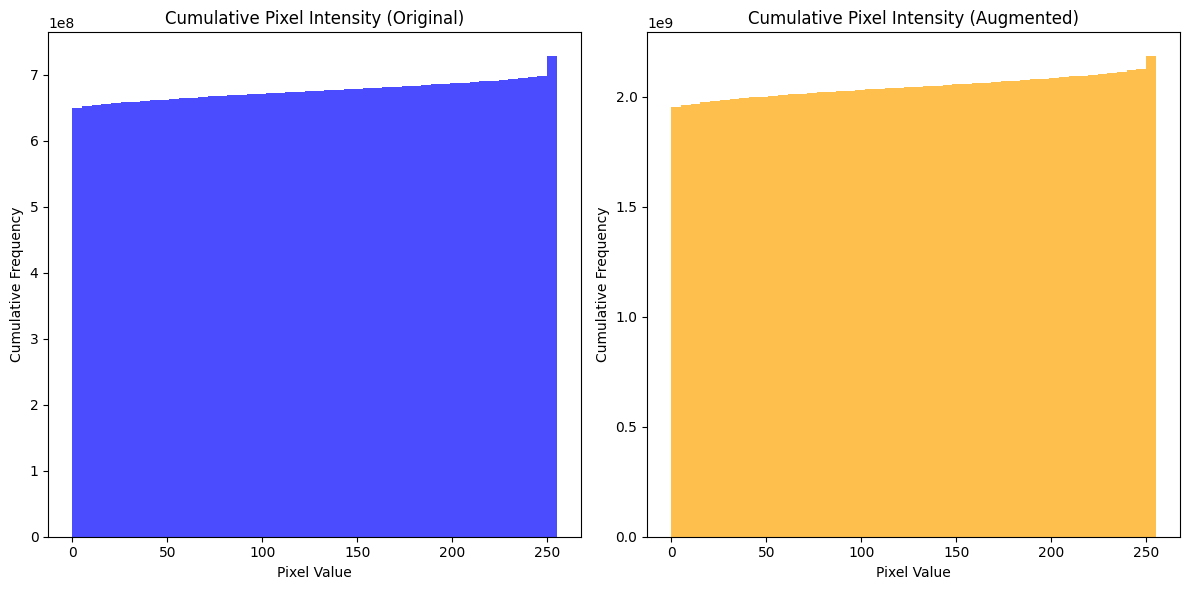

In [16]:
plt.figure(figsize=(12, 6))

# Cumulative histogram for original pixel values
plt.subplot(1, 2, 1)
plt.hist(pixel_values, bins=50, cumulative=True, alpha=0.7, color='blue')
plt.title("Cumulative Pixel Intensity (Original)")
plt.xlabel("Pixel Value")
plt.ylabel("Cumulative Frequency")

# Cumulative histogram for augmented pixel values
plt.subplot(1, 2, 2)
plt.hist(pixel_values_aug, bins=50, cumulative=True, alpha=0.7, color='orange')
plt.title("Cumulative Pixel Intensity (Augmented)")
plt.xlabel("Pixel Value")
plt.ylabel("Cumulative Frequency")

# Adjust layout
plt.tight_layout()
plt.show()